# Compiler syntax

Each line of the program will be translated to a specific location in the memory. Sequence of the program execution will be the same as the sequence of the instructions in the program.

Multiple instructions can be given within the same line. In this case, instructions should be separated with semicolon (`;`).

## Currently supported instruction set
 
###  ```nop```
Only used as a placeholder instruction.

###  ```generate op1```
Generates operand with the name ```op1```.

###  ```add op1, op2, op3```
Performs the addition of operands ```op2``` and ```op3``` and stores the result to ```op1```:

```op1<-op2+op3 ```

###  ```sub op1, op2, op3```
Performs the subtraction of operands ```op2``` and ```op2``` and stores the result to ```op1```:

```op1<-op2-op3 ```

### ```if condition instruction```
Executes the ```instruction``` if operand ```condition``` is present. Can be followed by multiple instruction separated by semicolon (```;```).

###  ```do-while condition instruction```
Instruction ```instruction``` is always executed for the first time and is executed until the operand ```condidtion``` is present.

###  ```while condition instruction```
Instruction ```instruction``` is executed only if and until the operand ```condition``` is present.

### ```halt```
Halts the processor at current instruction memory location.




# Testing the compiler
## Initialization

### Imports

In [1]:
from simulate_program import simulate_program
import numpy as np
import seaborn as sns

sns.set_style("white")

### Simulation parameters

In [30]:
t_end = 160 # duration in hours
N = 1000 # number of samples to display

### Program parameters

In [31]:
n_bits = 4 # number of bits in the instruction memory

# parameters defining the expression of operands
prog_alpha = 10
prog_delta = 0.1#0.01
prog_n = 2
prog_Kd = 10
params_prog  = prog_alpha, prog_delta, prog_n, prog_Kd

# proteolysis and induction of protease (conditional jumps)
deltaE = 250
KM = 100
KD_cond = 0.1

### Processor parameters
Use the parameter values that were obtained with the optimization framework proposed in Pušnik et al., 2019.

In [32]:
points = np.loadtxt('selected_points.txt')
params = points[0]

params_ff = list(params[:8])
params_addr = list(params[8:])


params_proteolysis = [deltaE, KM]
params_condition = [KD_cond]

## Examples of simple programs
Compiles a program stored in a given txt file and produces a python model that is simulate with the parameters given above.

### Addition
```
generate A
generate B
add C, A, B
```

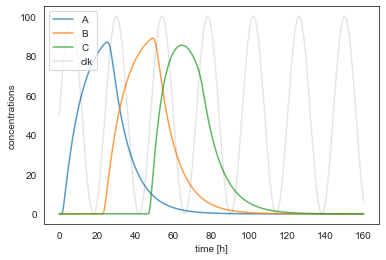

In [33]:
program_name = "programs\\program_add.txt"
simulate_program(program_name, t_end, N, params_ff, params_addr, params_proteolysis, params_condition, params_prog, n_bits)

### Subtraction
```
generate A
generate B
sub C, A, B
```

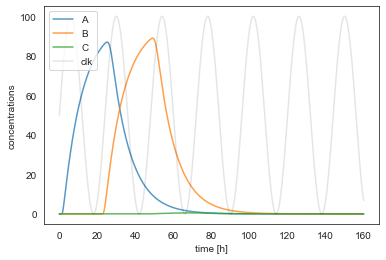

In [34]:
program_name = "programs\\program_sub.txt"
simulate_program(program_name, t_end, N, params_ff, params_addr, params_proteolysis, params_condition, params_prog, n_bits)

### Subtraction 2
```
generate A
sub C, A, B
```


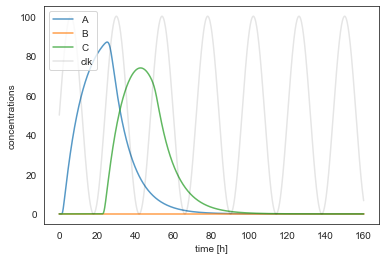

In [35]:
program_name = "programs\\program_sub_one.txt"
simulate_program(program_name, t_end, N, params_ff, params_addr, params_proteolysis, params_condition, params_prog, n_bits)

### Addition and halt
```
generate A
generate B
add C, A, B
halt
```


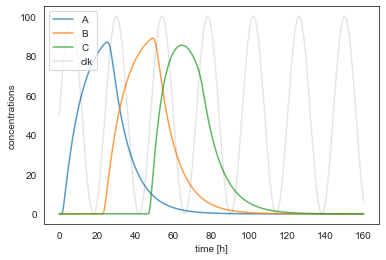

In [36]:
program_name = "programs\\program_add_halt.txt"
simulate_program(program_name, t_end, N, params_ff, params_addr, params_proteolysis, params_condition, params_prog, n_bits)

### Multiple additions, subtraction and halt
This example demonstrates the execution of multiple instruction in the same clock period.
```
generate A; generate B; add E, A, B
add C, A, B; sub D, A, B
halt
```


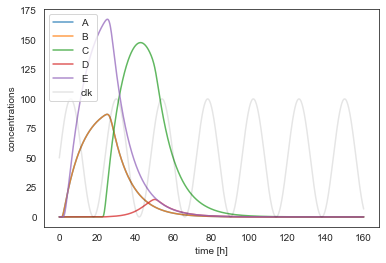

In [37]:
program_name = "programs\\program_add_multi.txt"
simulate_program(program_name, t_end, N, params_ff, params_addr, params_proteolysis, params_condition, params_prog, n_bits)

### If-then
Condition is fulfilled
```
generate A
generate B
if B add C, A, B
```


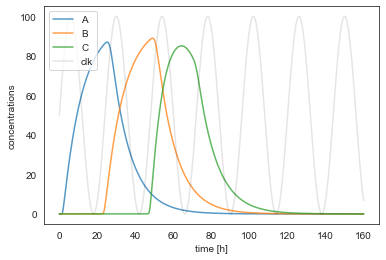

In [38]:
program_name = "programs\\program_if.txt"
simulate_program(program_name, t_end, N, params_ff, params_addr, params_proteolysis, params_condition, params_prog, n_bits)

Condition is not fulfilled
```
generate A
if B add C, A, B
```


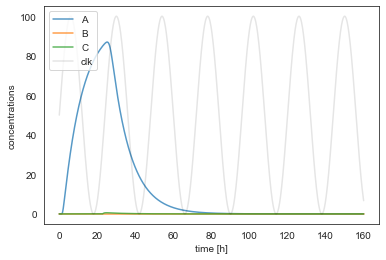

In [39]:
program_name = "programs\\program_if_false.txt"
simulate_program(program_name, t_end, N, params_ff, params_addr, params_proteolysis, params_condition, params_prog, n_bits)

### While
```
generate A
while A generate C
```


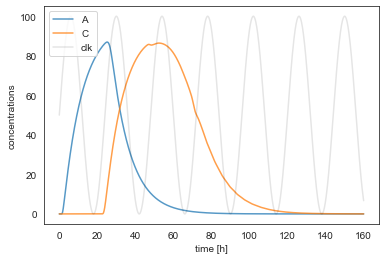

In [40]:
program_name = "programs\\program_while.txt"
simulate_program(program_name, t_end, N, params_ff, params_addr, params_proteolysis, params_condition, params_prog, n_bits)